In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

/home/evan/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/evan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.2).tolist()

tensor([4, 2, 7, 5, 1, 5, 7, 7, 9, 3])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

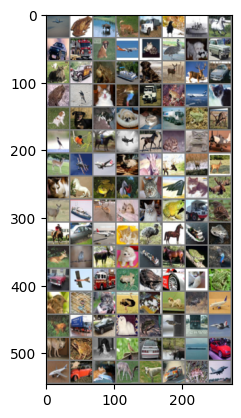

frog  frog  deer  dog   truck bird  ship  horse bird  truck dog   plane cat   plane dog   truck deer  car   frog  ship  dog   deer  deer  car   frog  truck cat   bird  truck frog  plane cat   ship  dog   cat   dog   horse truck frog  deer  plane bird  horse truck horse frog  cat   plane deer  ship  plane bird  deer  deer  ship  deer  cat   car   horse dog   cat   plane cat   deer  deer  ship  deer  cat   cat   frog  truck bird  horse car   plane truck bird  truck ship  dog   deer  horse deer  dog   ship  horse car   bird  car   plane truck frog  frog  car   cat   frog  bird  dog   cat   bird  cat   dog   deer  dog   deer  truck car   dog   frog  frog  truck car   dog   frog  dog   bird  horse deer  ship  car   plane car   car   deer  dog   car   frog  deer 


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
net = ResNet()
net = net.to(device)

In [9]:
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
lossi = []
testi = []

In [11]:
def estimate_loss(split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    return loss / len(loader)

In [12]:
epochs = 32

for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        lossi.append(loss.item())
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'[{epoch}, {i}] loss: {loss.item()}')

    test_loss = estimate_loss("test")
    print(f'[{epoch}] test loss: {test_loss}')
    testi.append(test_loss)


[0, 0] loss: 2.434558868408203
[0, 200] loss: 1.85061776638031
[0] test loss: 1.4506157983707477
[1, 0] loss: 1.7654800415039062
[1, 200] loss: 1.6370656490325928
[1] test loss: 1.3020889336549784
[2, 0] loss: 1.6909159421920776
[2, 200] loss: 1.4853326082229614
[2] test loss: 1.2030370582508136
[3, 0] loss: 1.7373207807540894
[3, 200] loss: 1.50950288772583
[3] test loss: 1.110773902150649
[4, 0] loss: 1.386932373046875
[4, 200] loss: 1.3855648040771484
[4] test loss: 1.0576444094694113
[5, 0] loss: 1.3875924348831177
[5, 200] loss: 1.46669602394104
[5] test loss: 1.0230207299884362
[6, 0] loss: 1.299379825592041
[6, 200] loss: 1.4781981706619263
[6] test loss: 0.9960859085940108
[7, 0] loss: 1.287419319152832
[7, 200] loss: 1.401705265045166
[7] test loss: 0.9283029535148717
[8, 0] loss: 1.3767269849777222
[8, 200] loss: 1.3764079809188843
[8] test loss: 0.9254129227203659
[9, 0] loss: 1.3974201679229736
[9, 200] loss: 1.3933237791061401
[9] test loss: 0.8876225216479241
[10, 0] loss

In [13]:
def check_accuracy(split="test"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    net.train()
    print(f'{split} accuracy: {correct / total}')
    return correct / total

check_accuracy("test")
check_accuracy("train")

test accuracy: 0.6828
train accuracy: 0.94308


0.94308

In [14]:
import matplotlib.pyplot as plt

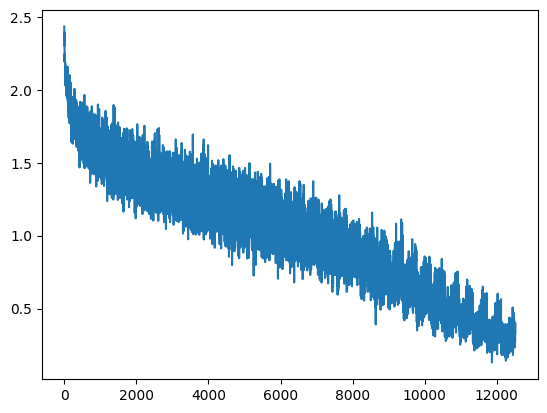

In [15]:
plt.plot(lossi)

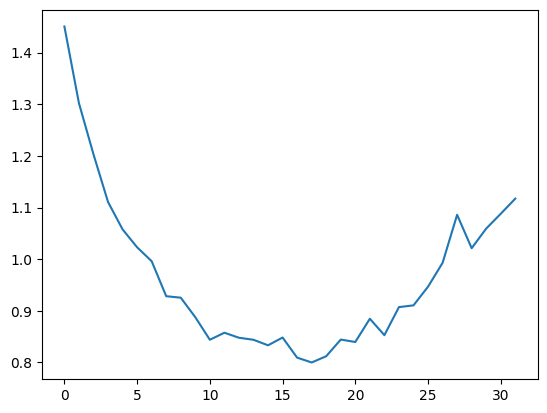

In [16]:
plt.plot(testi)